# Example of causal survival model with binary treatment

see also
https://academic.oup.com/bioinformatics/article/38/Supplement_1/i60/6617509

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

from tensorflow.keras import regularizers


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
tfk = tf.keras

import importlib

In [3]:
import pypsps
import pypress

from pypsps.datasets import base, binary_survival, bites

import pypress.keras.layers
import pypress.keras.regularizers

from pypsps.keras import neglogliks
from pypsps.keras import losses
import pypsps.keras.callbacks
import pypsps.datasets.survival_data
import pypsps.keras.models
import pypsps.utils as utils
import pypsps.inference

## Simulate continuous treatment dataset

In [8]:

simulator = binary_survival.CancerSurvivalSimulator()
surv_data = simulator.sample(n_samples=1000)
print(surv_data)


In [9]:
surv_data.features

,gender,age,comorbidity,cancer_severity
patient_id,,,,
lg0i,0,31.454263,0,9.965645
lg9m,1,31.884567,1,9.743891
lg67,0,33.152182,0,9.856364
lg5u,0,33.071906,0,9.694956
lg9j,1,34.562646,0,9.807443
...,...,...,...,...
lg3r,1,71.867706,1,1.044829
lg29,1,74.147696,1,1.255419
lfpy,0,77.410922,1,1.509929


In [10]:
# Simulation of data
features = surv_data.features
treatment = surv_data.treatments
outcomes = surv_data.outcomes

# train / test split
X_train, X_test, t_train, t_test, outcomes_train, outcomes_test = train_test_split(
    features, treatment, outcomes, test_size=0.2, random_state=42)

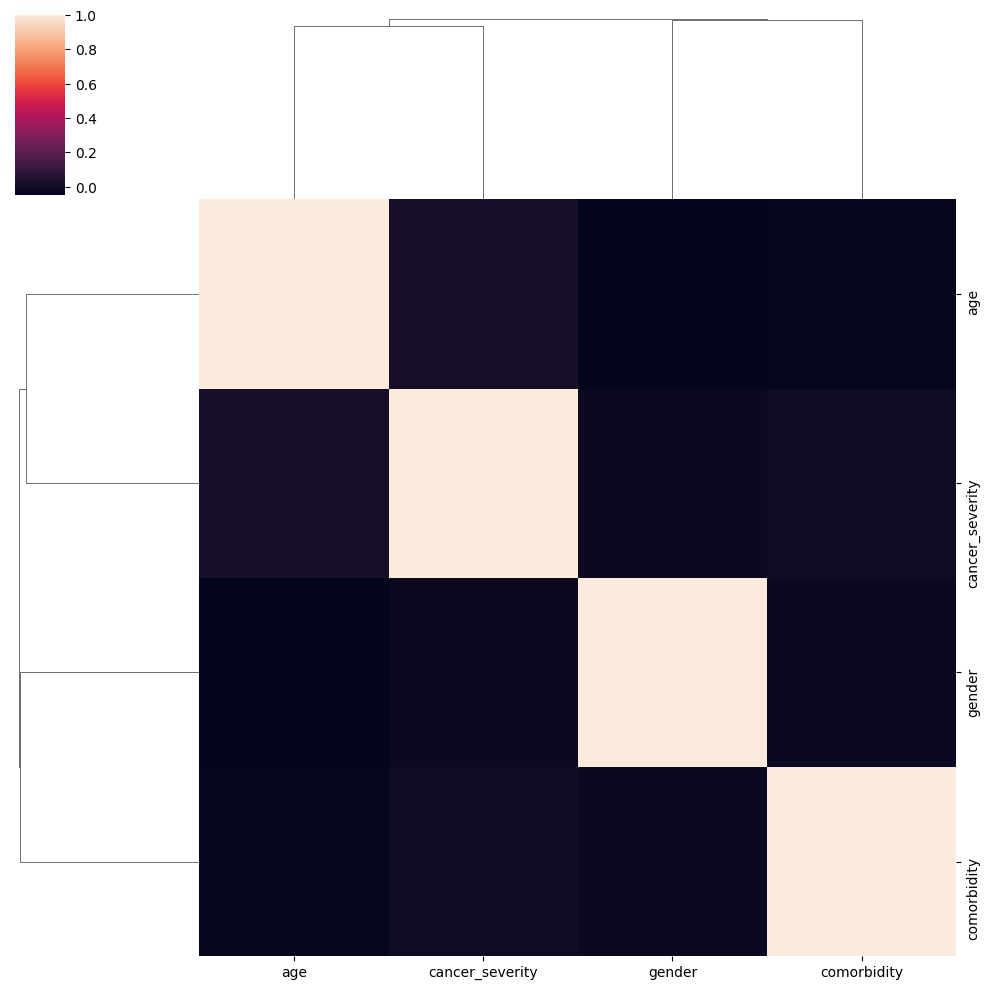

In [11]:
sns.clustermap(X_train.corr("spearman"))

In [12]:
sdf = surv_data.to_data_frame()
sdf.mean()

event_time            209.074405
event_indicator         0.854000
chemotherapy            0.654000
gender                  0.485000
age                    55.076692
comorbidity             0.676000
cancer_severity         5.361592
true_recovery_time    277.890379
prob_chemotherapy       0.656659
dtype: float64

In [13]:
sdf.groupby("chemotherapy").mean()

,event_time,event_indicator,gender,age,comorbidity,cancer_severity,true_recovery_time,prob_chemotherapy
chemotherapy,,,,,,,,
0,336.554502,0.635838,0.462428,60.466475,0.624277,3.779318,528.474465,0.466193
1,141.630806,0.969419,0.496942,52.225216,0.703364,6.198697,145.318370,0.757425


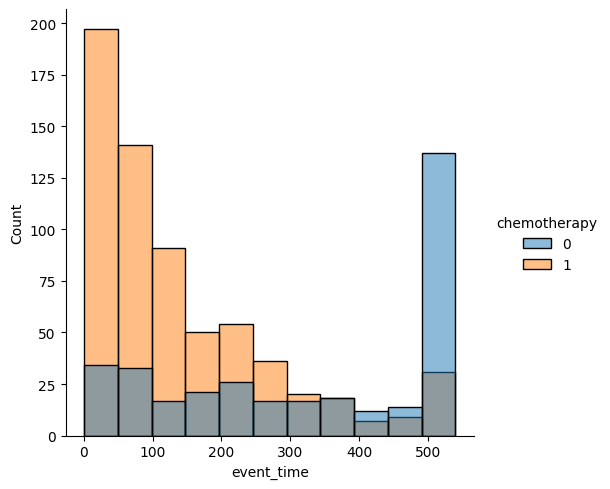

In [14]:
sns.displot(data=sdf, x="event_time", hue="chemotherapy")

## Build & train model

In [127]:
importlib.reload(pypsps.keras.models)

model = pypsps.keras.models.build_model_binary_exponential(
    n_states=4, 
    n_features=X_train.shape[1],
    predictive_state_hidden_layers=[(20, "selu"), (20, "relu")],
    outcome_hidden_layers=[(30, "selu"), (20, "tanh")],
    log_rate_layer=(30, "selu"),
    df_penalty_l1=1.,
    alpha=1.,
    outcome_loss_weight=2.,
    learning_rate=0.01,
)

model.summary()


/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 4)         │         16 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_and_treat… │ (None, 5)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 30)        │        180 │ features_and_tre… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 30)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 20)        │        100 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30)        │        120 │ dropout_18[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 20)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 20)        │        620 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dropout_16[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 20)        │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 20)        │        420 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dropout_19[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 20)        │          0 │ dense_17[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 25)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_and_tre… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dropout_17[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_rate_feat_eng_… │ (None, 30)        │        780 │ concatenate_9[0]… │
│ (Dense)             │                   │            │                 

 Total params: 5,044 (19.70 KB)

 Trainable params: 4,856 (18.97 KB)

 Non-trainable params: 188 (752.00 B)

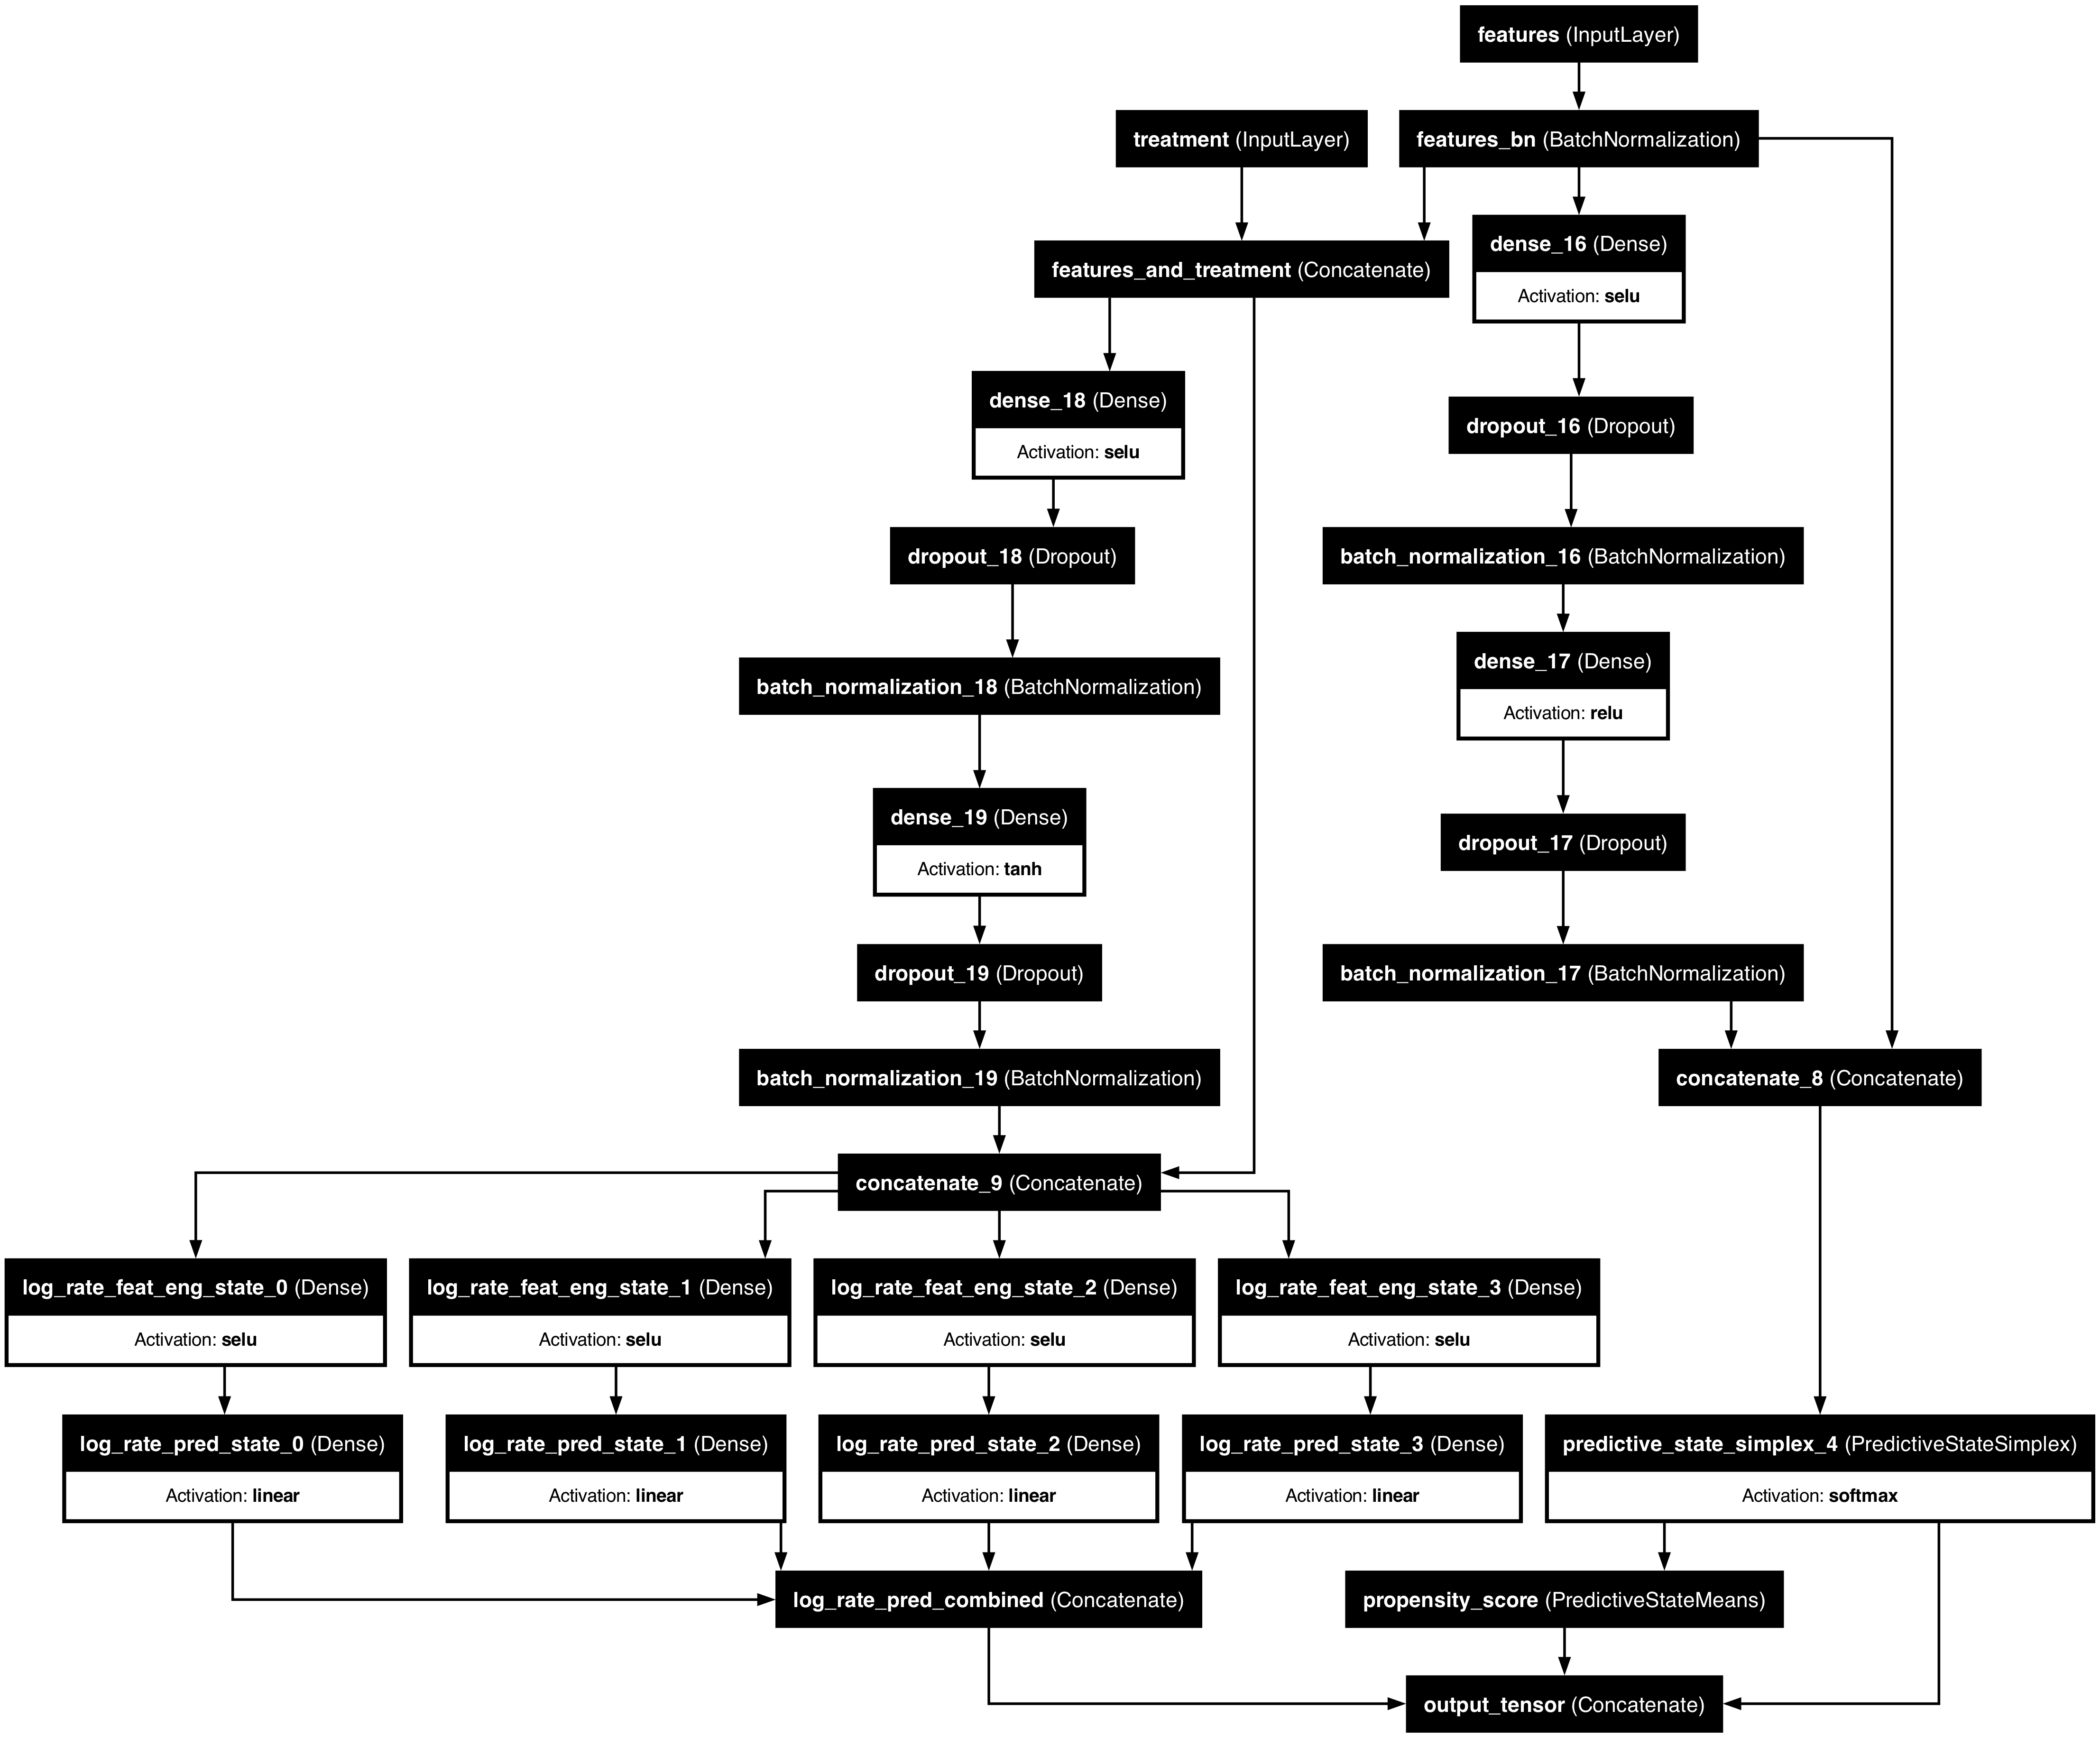

In [128]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_layer_activations=True)

In [129]:
model.predict([features, treatment])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[10.175564 ,  2.3393188, -2.486684 , ...,  0.25     ,  0.25     ,
         0.6018534],
       [10.433988 ,  2.231559 , -2.1785839, ...,  0.25     ,  0.25     ,
         0.6018534],
       [11.0077915,  2.606542 , -2.755926 , ...,  0.25     ,  0.25     ,
         0.6018534],
       ...,
       [34.50465  , 10.172054 , -7.2000823, ...,  0.25     ,  0.25     ,
         0.6018534],
       [34.376736 ,  9.95993  , -7.0762305, ...,  0.25     ,  0.25     ,
         0.6018534],
       [35.845047 , 10.463274 , -7.7395372, ...,  0.25     ,  0.25     ,
         0.6018534]], dtype=float32)

In [130]:
importlib.reload(pypsps.keras.callbacks)
history = model.fit(
    [X_train.values, t_train.values], 
    tf.concat([outcomes_train.values, t_train.values], axis=1),
    validation_split=0.2,
    verbose=0,
    epochs=500,
    batch_size=32,
    callbacks=pypsps.keras.callbacks.recommended_callbacks("val_causal_loss"),
)

Epoch 1: causal_loss=135.5851, loss=270.5511, predictive_state_df=1.0689, val_causal_loss=83.3720, val_loss=166.1652, val_predictive_state_df=1.0526, learning_rate=0.0100
Epoch 20: causal_loss=6.2944, loss=12.3232, predictive_state_df=1.5206, val_causal_loss=5.8146, val_loss=11.3290, val_predictive_state_df=1.4577, learning_rate=0.0100
Epoch 40: causal_loss=6.1813, loss=11.8149, predictive_state_df=1.0737, val_causal_loss=5.8181, val_loss=11.0916, val_predictive_state_df=1.0611, learning_rate=0.0100
Epoch 60: causal_loss=6.0912, loss=11.6471, predictive_state_df=1.0699, val_causal_loss=5.7923, val_loss=11.0484, val_predictive_state_df=1.0562, learning_rate=0.0100
Epoch 80: causal_loss=6.0503, loss=11.5685, predictive_state_df=1.0682, val_causal_loss=5.7903, val_loss=11.0516, val_predictive_state_df=1.0591, learning_rate=0.0010
Epoch 100: causal_loss=6.0558, loss=11.5817, predictive_state_df=1.0686, val_causal_loss=5.7902, val_loss=11.0508, val_predictive_state_df=1.0582, learning_rate=

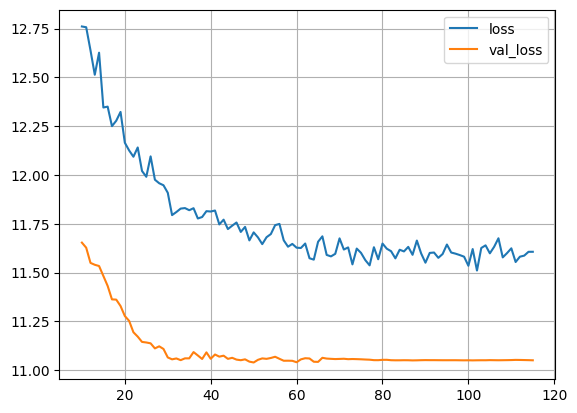

In [132]:
pd.DataFrame(history.history)[["loss", "val_loss"]].tail(-10).plot()
plt.grid()

<Axes: >

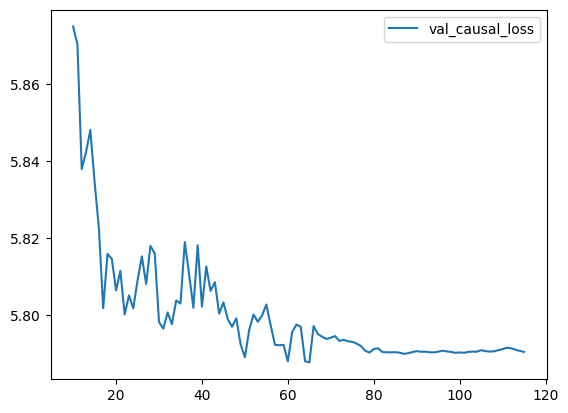

In [133]:
pd.DataFrame(history.history)[["val_causal_loss"]].tail(-10).plot()


<Axes: >

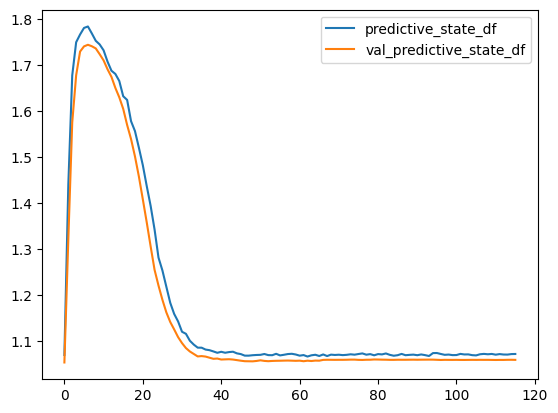

In [134]:
pd.DataFrame(history.history)[["predictive_state_df", "val_predictive_state_df"]].plot()

<Axes: >

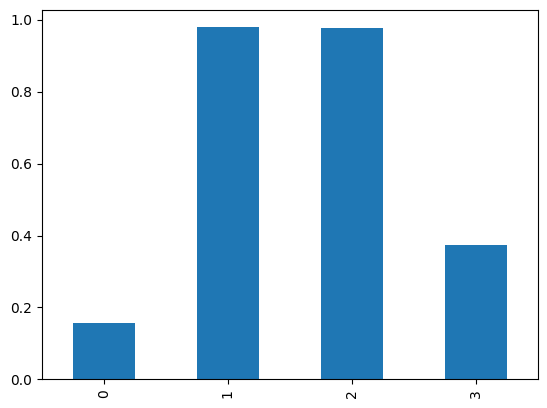

In [135]:
pd.Series(model.layers[-2].state_conditional_means.numpy().ravel()).plot.bar()

In [136]:
preds = model.predict([X_train, t_train], verbose=0)
op, wp, tp = utils.split_y_pred(preds, 1, 1)

In [137]:
rate_preds = pd.DataFrame(1. / np.exp(op))

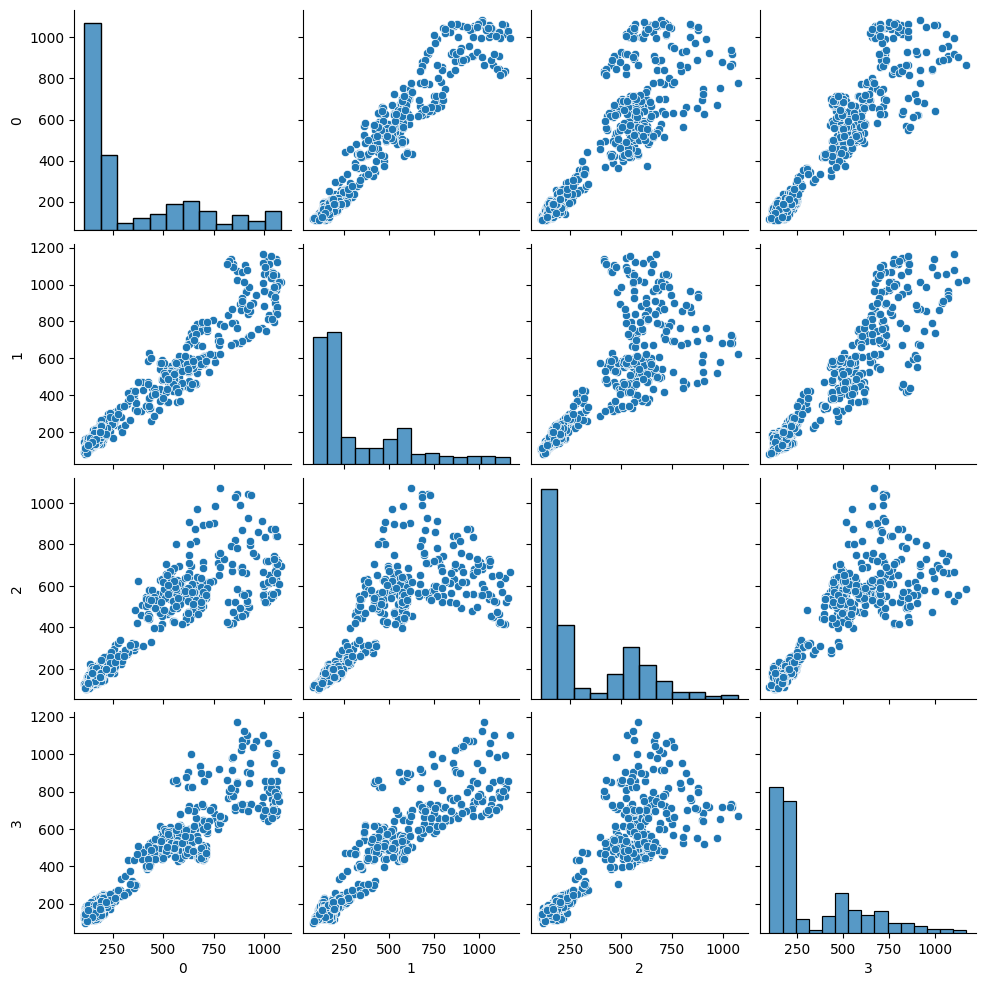

In [138]:
sns.pairplot(rate_preds)

In [139]:
sdf["pred_rate"] = np.nan
sdf.loc[t_train.index, "pred_rate"] = 1 / np.exp((np.log(1 / rate_preds) * wp).sum(axis=1).ravel())

/var/folders/8z/h14m58j90330cxkpzsn4z09h0000gn/T/ipykernel_31230/561791433.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sdf.loc[t_train.index, "pred_rate"] = 1 / np.exp((np.log(1 / rate_preds) * wp).sum(axis=1).ravel())


In [140]:
sdf

,event_time,event_indicator,chemotherapy,gender,age,comorbidity,cancer_severity,true_recovery_time,prob_chemotherapy,pred_rate
patient_id,,,,,,,,,,
lg0i,34.933883,1,1,0,31.454263,0,9.965645,34.933883,0.987992,196.966919
lg9m,5.920997,1,1,1,31.884567,1,9.743891,5.920997,0.986316,274.394470
lg67,178.245513,1,1,0,33.152182,0,9.856364,178.245513,0.986219,199.254593
lg5u,31.551600,1,1,0,33.071906,0,9.694956,31.551600,0.985137,199.381271
lg9j,81.107874,1,1,1,34.562646,0,9.807443,81.107874,0.984866,206.563889
...,...,...,...,...,...,...,...,...,...,...
lg3r,35.056527,1,0,1,71.867706,1,1.044829,35.056527,0.111950,NaN
lg29,349.602725,1,0,1,74.147696,1,1.255419,349.602725,0.111088,841.010742
lfpy,540.000000,0,0,0,77.410922,1,1.509929,688.658447,0.107592,666.630493


<Axes: xlabel='event_time', ylabel='pred_rate'>

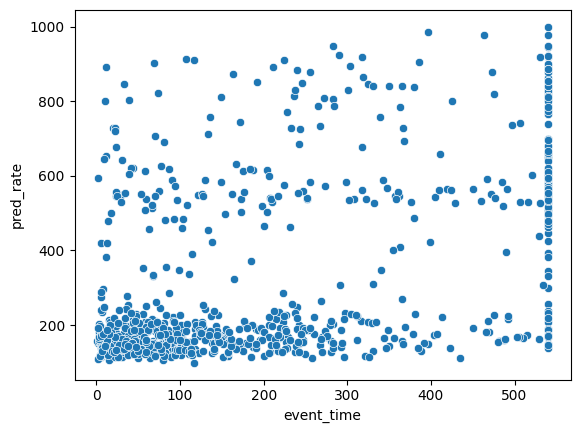

In [141]:
sns.scatterplot(data=sdf, x="event_time", y="pred_rate")

In [142]:
t_train

,chemotherapy
patient_id,
lg4m,1
lg01,0
lfsh,1
lfml,1
lgbz,0
...,...
lgca,1
lg9w,1
lga7,1


In [143]:
tp.shape, t_train.shape

((800, 1), (800, 1))

In [144]:
tmp = pd.Series(tp.ravel(), name="pred_propensity_score").to_frame()
tmp["treatment"] = t_train.values.ravel()
tmp["true_propensity_score"] = surv_data.to_data_frame().loc[t_train.index]["prob_chemotherapy"].values
tmp

,pred_propensity_score,treatment,true_propensity_score
0,0.799293,1,0.974297
1,0.617507,0,0.680445
2,0.577143,1,0.521676
3,0.597472,1,0.650744
4,0.515849,0,0.343945
...,...,...,...
795,0.747456,1,0.941375
796,0.704438,1,0.876071
797,0.508970,1,0.316948
798,0.623793,0,0.770932


<Axes: xlabel='pred_propensity_score', ylabel='true_propensity_score'>

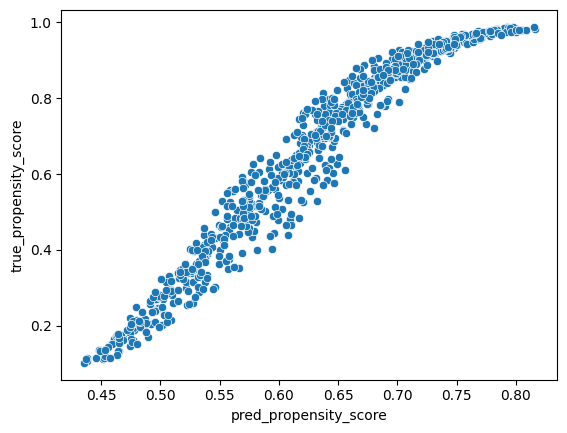

In [145]:
sns.scatterplot(tmp, x="pred_propensity_score", y="true_propensity_score")

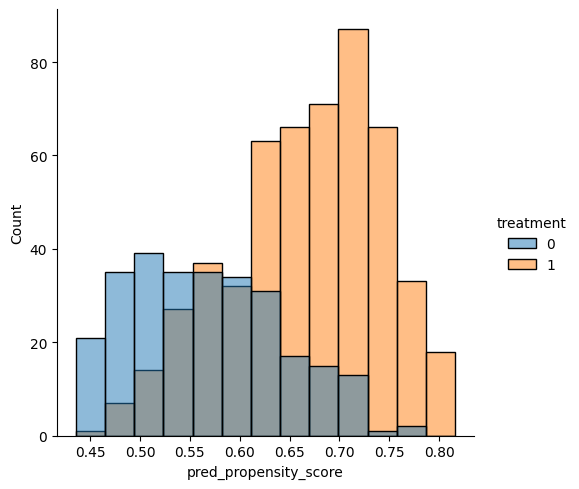

In [146]:
sns.displot(data=tmp, x="pred_propensity_score", hue="treatment")

<Axes: >

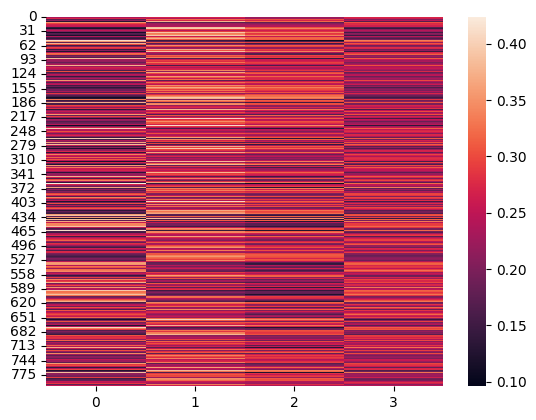

In [147]:
sns.heatmap(wp)

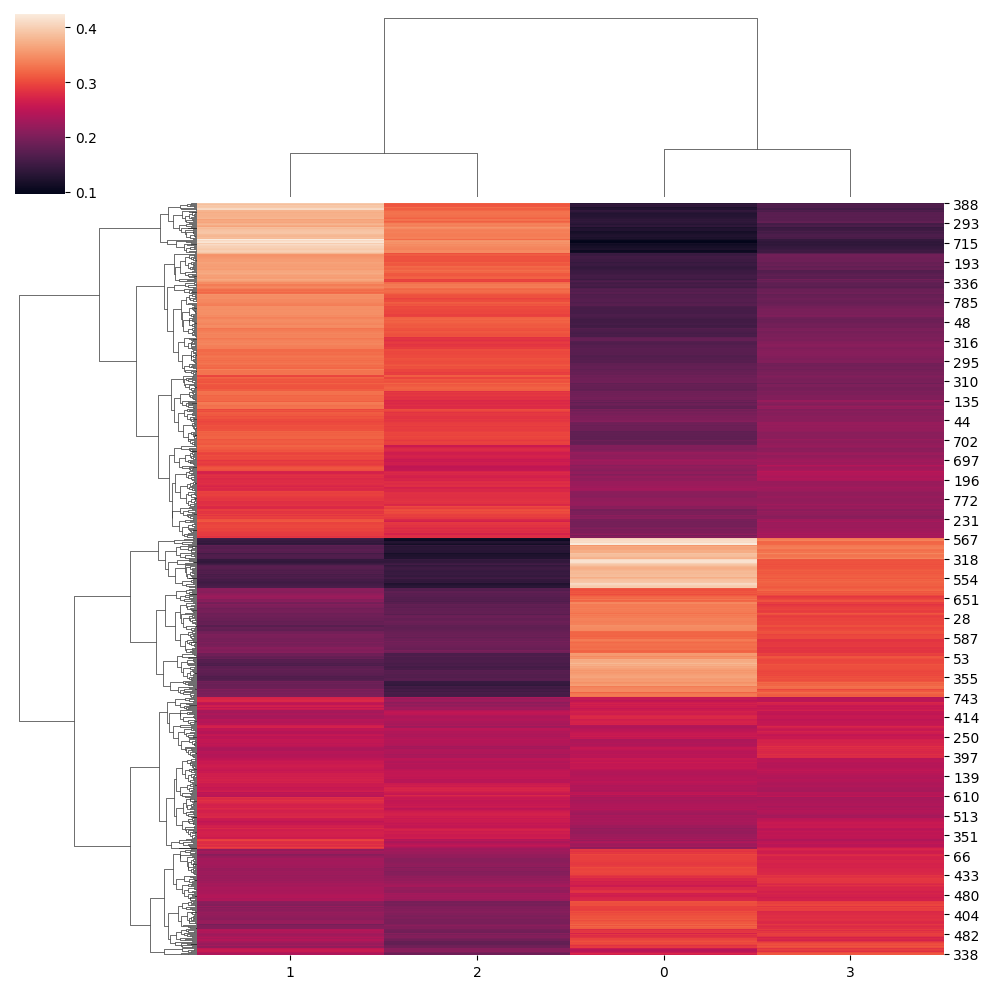

In [148]:
sns.clustermap(wp)

<Axes: >

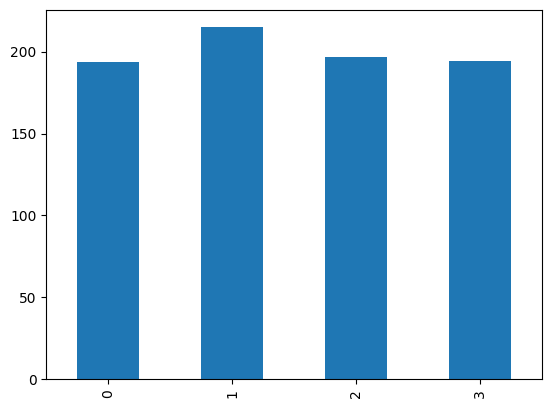

In [149]:
pd.Series(pypress.utils.state_size(wp)).plot.bar()

In [150]:
pypress.utils.tr_kernel(wp)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0614612102508545>

In [151]:
pred_utes = pypsps.inference.predict_ute_binary(model, features=surv_data.features)

<Axes: xlabel='patient_id'>

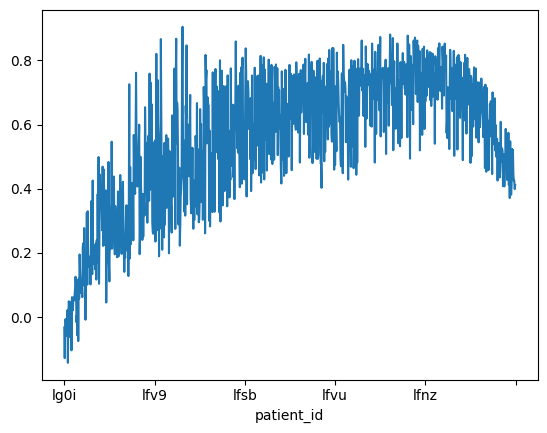

In [152]:
pred_utes.plot()

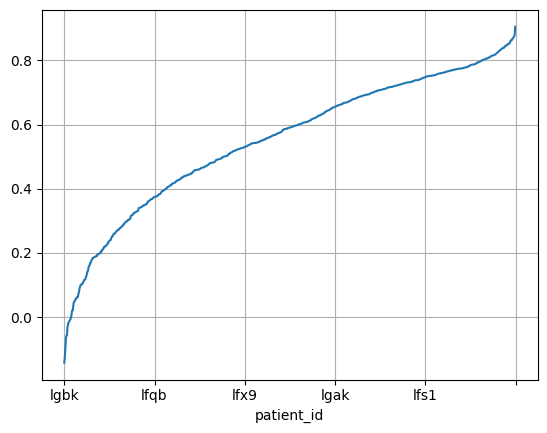

In [153]:
pred_utes.sort_values().plot()
plt.grid()

In [154]:
pypsps.inference.predict_ate_binary(model, features=surv_data.features)

np.float32(0.55220693)